# Modeling: Подготовка датасетов и построение моделей

В этом разделе мы готовим данные и строим модели для **прогноза почасового спроса на самокаты**. Основная цель — понять, какие факторы влияют на спрос, и построить модель, которая позволяет прогнозировать его на будущее.

**Основные шаги:**

1. **Импорт библиотек**
   Подключаем стандартные библиотеки для анализа данных (`pandas`, `numpy`, `matplotlib`, `seaborn`) и пользовательские утилиты для визуализации и подготовки признаков.

2. **Загрузка очищенных данных**
   Используем нормализованный и предварительно очищенный датасет `rides_weather_data.csv`.

3. **Подготовка данных и построение модели**
   Проводим полный пайплайн работы с данными:
   * формируем почасовой датасет спроса;
   * создаем временные и лаговые признаки;
   * кодируем категориальные признаки с помощью One-Hot Encoding (OHE);
   * разделяем данные на тренировочную и тестовую выборки;
   * обучаем линейную регрессионную модель;
   * оцениваем качество модели с помощью MAE и R^2.

В результате этих шагов мы получаем модель, которая позволяет прогнозировать почасовой спрос и анализировать влияние различных факторов: календарных, погодных, географических и маркетинговых.

## 1. Импорт библиотек

Импортируем стандартные библиотеки для анализа данных, а также пользовательские функции для визуализации и первичного осмотра данных.

In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression

try:
    from utils.paths import join_path as pj
    from utils.modeling import build_hourly_dataset, add_lag_features, train_test_time_split, apply_ohe
    from utils.overview import print_model_metrics
    from utils.vizualization import plot_actual_vs_predicted, plot_residuals_distribution
except ImportError:
    from scooter_sharing_analysis.utils.paths import join_path as pj
    from scooter_sharing_analysis.utils.modeling import (
        build_hourly_dataset, add_lag_features, train_test_time_split, apply_ohe
    )
    from scooter_sharing_analysis.utils.overview import print_model_metrics
    from scooter_sharing_analysis.utils.vizualization import plot_actual_vs_predicted, plot_residuals_distribution


## 2. Загрузка очищенных данных

Загружаем файл rides_weather_data.csv нормализованный после очистки.

In [2]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_weather_options = {
    "filepath_or_buffer": pj("data", "rides_weather_data.csv"),
    "encoding": "utf-8",
    "parse_dates": ["start_date", "end_date", "day_timestamp", "hour_timestamp"],
}

rides_weather_data = pd.read_csv(**rides_weather_options)

## 3. Подготовка данных и построение модели спроса

В этом блоке выполняется полный пайплайн работы с данными для прогноза почасового спроса на поездки:

* создание временных и лаговых признаков
* кодирование категориальных данных
* обучение модели
* оценка качества модели

### 3.1. Почасовой датасет

Агрегируем данные о поездках до почасового уровня, чтобы построить модель прогноза спроса.

In [3]:
data = build_hourly_dataset(rides_weather_data)

### 3.2. Лаговые признаки

Добавляем лаговые признаки, чтобы учитывать автокорреляцию спроса:
* lag_1h — спрос за предыдущий час
* lag_24h — спрос за аналогичный час предыдущего дня
* mean_last_24h — средний спрос за последние 24 часа
* mean_last_7d — средний спрос за последние 7 дней

In [4]:
data = add_lag_features(data)

### 3.3. Разделение на тренировочную и тестовую выборки

In [5]:
X_train, X_test, y_train, y_test = train_test_time_split(data)

### 3.4. Кодирование категориальных признаков

Категориальные признаки (promo, day_of_week) кодируем с помощью OHE.

In [6]:
cat_cols = ["promo", "day_of_week"]

X_train_final, X_test_final = apply_ohe(
    X_train, X_test, categorical_cols=cat_cols
)

### 3.5. Обучение модели

In [7]:
model = LinearRegression()
model.fit(X_train_final, y_train)

pred = model.predict(X_test_final)

### 3.6. Оценка качества модели

Метрики:
* MAE — средняя абсолютная ошибка (цель ≤ 15)
* R^2 — коэффициент детерминации (цель ≥ 0.7)

In [8]:
print_model_metrics(y_test, pred, mae_threshold=15, r2_threshold=0.7)

R^2: 0.76 | MAE: 11.66


## 4. Визуализация результатов моделирования

### 4.1. Фактический спрос vs прогноз модели

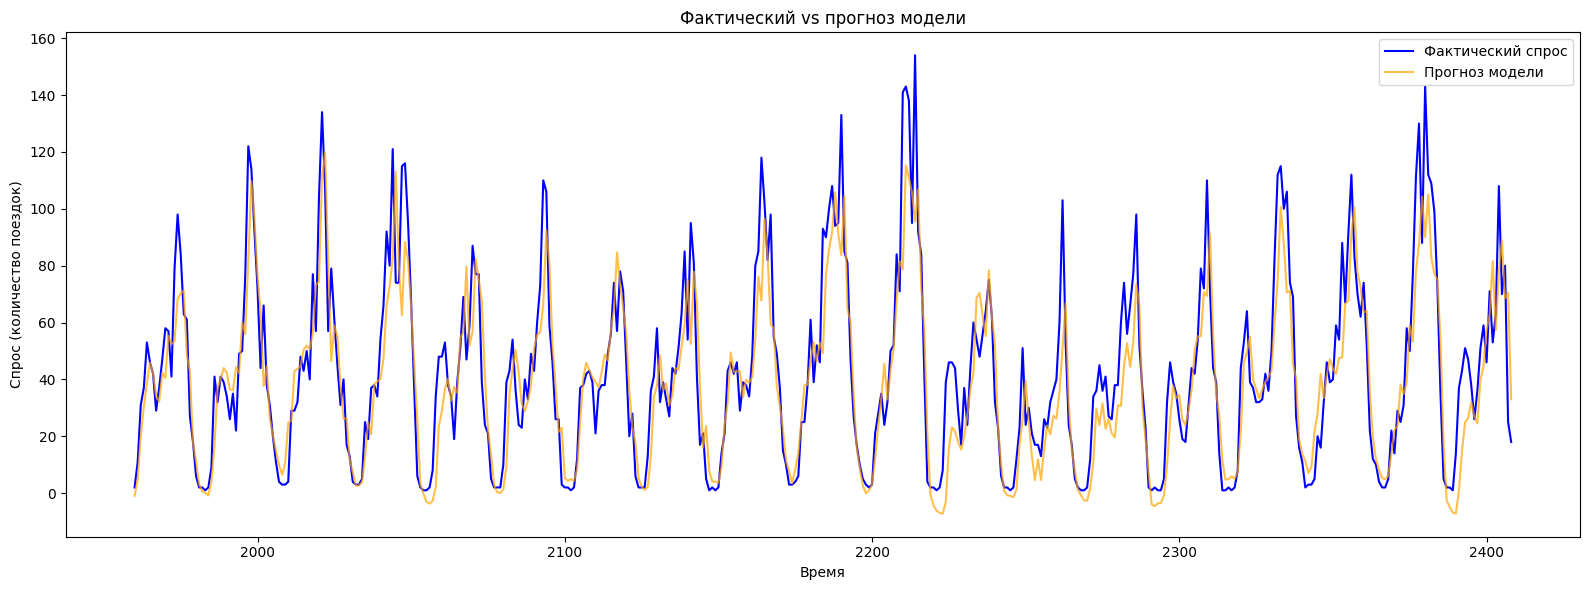

In [9]:
plot_actual_vs_predicted(y_test, pred)

График фактических и предсказанных значений почасового спроса показывает, что модель хорошо воспроизводит общую динамику спроса, включая суточные и недельные паттерны. Прогнозы близко следуют за реальными значениями, без заметного систематического смещения.

### 4.2. Распределение остатков модели

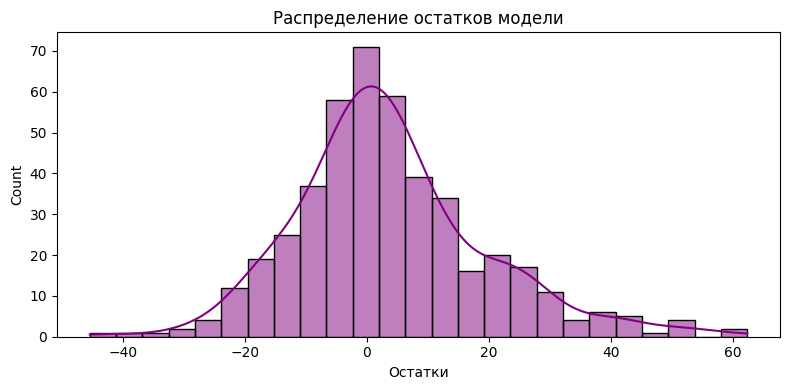

In [10]:
plot_residuals_distribution(y_test, pred)

Для оценки корректности построенной линейной модели был проведён анализ остатков — разницы между фактическими и предсказанными значениями спроса.

Распределение остатков оказалось близким к нормальному и симметричным относительно нуля. Это указывает на отсутствие систематического смещения модели: ошибки прогноза носят случайный характер и не смещены в сторону переоценки или недооценки спроса.

## Итоговый вывод по регрессионному моделированию

В рамках анализа почасового спроса на самокаты была построена линейная регрессионная модель.

### Подготовка данных
1. Сформирован почасовой датасет с агрегированными признаками:
   - календарные (`hour_of_day`, `day_of_week`, `day_of_week_type`),
   - погодные (`temperature`, `precipitation_total`),
   - маркетинговые (`promo`).
2. Созданы лаговые признаки спроса:
   - `lag_1h` — спрос за предыдущий час,
   - `lag_24h` — спрос за предыдущие сутки,
   - `mean_last_24h` и `mean_last_7d` — средний спрос за последние 24 часа и 7 дней.
3. Проведено разделение на тренировочную и тестовую выборки по времени (без перемешивания), чтобы предсказывать будущее на основе прошлого.
4. Категориальные признаки закодированы с помощью OHE.

### Результаты модели
- **R^2:** 0.76 — модель объясняет 76% вариации почасового спроса.
- **MAE:** 11.66 — средняя ошибка прогноза ≈ 11–12 поездок в час.

### Выводы
- Основными драйверами спроса являются лаговые признаки и календарные факторы.
- Погодные условия и промо оказывают дополнительное, но менее сильное влияние.
- Модель уже даёт достаточно точные прогнозы для анализа текущей эффективности и подготовки к динамическому ценообразованию.